In [75]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt

In [76]:
class ModelInformation:


    def __init__(self, model_name, use_gradients):
        self.model_name = model_name
        self.model, self.imagenet_accuracy = self.get_model(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.use_gradients = use_gradients
        self.inference_speed = self.compute_inference_speed()
        self.num_parameters = self.compute_num_parameters()
        self.vram_memory = self.compute_vram_usage()
        self.model = None

    
    def get_model(self, model_name):
        name = model_name.lower()
        if name == "vgg11":
            return models.vgg11(weights="VGG11_Weights.IMAGENET1K_V1"), 69.020
        elif name == "vgg11_bn":
            return models.vgg11_bn(weights="VGG11_BN_Weights.IMAGENET1K_V1"), 70.370
        elif name == "resnet18":
            return models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"), 69.758
        elif name == "resnet34":
            return models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1"), 73.314
        elif name == "densenet121":
            return models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1"), 74.434
        elif name == "mobilenet_v3_small":
            return models.mobilenet_v3_small(weights="MobileNet_V3_Small_Weights.IMAGENET1K_V1"), 67.668
        else:
            raise Exception("Given an invalid model name")

    
    def compute_inference_speed(self, num_iterations=100):
        INPUT_SHAPE = (1, 3, 40, 40)
        self.model.eval()
        avg_time = 0

        if self.use_gradients:
            for _ in range(num_iterations):
                start_time = time.time()
                
                image = torch.rand(INPUT_SHAPE)
                image = image.to(self.device)
                self.model(image)
                avg_time += time.time() - start_time
        else:
            with torch.no_grad():
                for _ in range(num_iterations):
                    start_time = time.time()
                    
                    image = torch.rand(INPUT_SHAPE)
                    image = image.to(self.device)
                    self.model(image)
                    avg_time += time.time() - start_time

        return round(1000 * avg_time / num_iterations, 3)

    
    def compute_num_parameters(self):
        return sum(parameter.numel() for parameter in self.model.parameters())

    
    def compute_vram_usage(self):
        INPUT_SHAPE = (64, 3, 40, 40)
        self.model.eval()

        if self.use_gradients:
            image = torch.rand(INPUT_SHAPE)
            image = image.to(self.device)
            output = self.model(image)
            vram = torch.cuda.memory_allocated()
            output = None 
        else:
            with torch.no_grad():
                image = torch.rand(INPUT_SHAPE)
                image = image.to(self.device)
                output = self.model(image)
                vram = torch.cuda.memory_allocated()
                output = None 
        
        return vram

    
    def get_inference_speed(self):
        return self.inference_speed

    
    def get_num_parameters(self):
        return self.num_parameters

    
    def get_imagenet_accuracy(self):
        return self.imagenet_accuracy

    
    def get_vram_usage(self):
        return self.vram_memory
    

    def get_model_name(self):
        return self.model_name

In [77]:
info_with_gradients = [
    ModelInformation("vgg11", True),
    ModelInformation("vgg11_bn", True),
    ModelInformation("resnet18", True),
    ModelInformation("resnet34", True),
    ModelInformation("densenet121", True),
    ModelInformation("mobilenet_v3_small", True)
]


info_no_gradients = [
    ModelInformation("vgg11", False),
    ModelInformation("vgg11_bn", False),
    ModelInformation("resnet18", False),
    ModelInformation("resnet34", False),
    ModelInformation("densenet121", False),
    ModelInformation("mobilenet_v3_small", False)
]

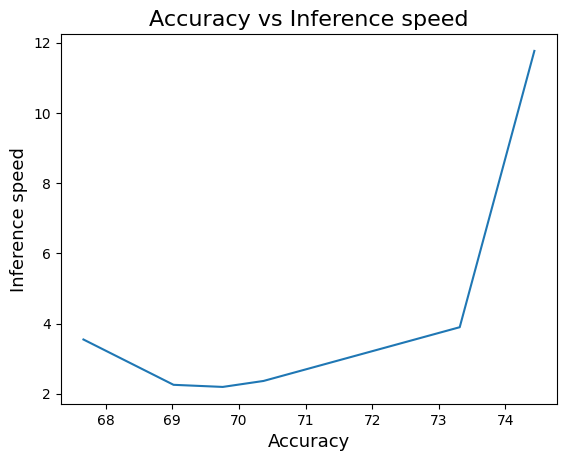

In [78]:
accuracies = [info.get_imagenet_accuracy() for info in info_no_gradients]
inference_speed_times = [info.get_inference_speed() for info in info_no_gradients]

accuracies, inference_speed_times = zip(*sorted(zip(accuracies, inference_speed_times)))

plt.title("Accuracy vs Inference speed", fontsize='16')
plt.plot(accuracies, inference_speed_times)
plt.xlabel("Accuracy", fontsize="13")
plt.ylabel("Inference speed", fontsize="13")
plt.show()

[2.255, 2.365, 2.195, 3.896, 11.766, 3.546]
[132863336, 132868840, 11689512, 21797672, 7978856, 2542856]
(2.195, 2.255, 2.365, 3.546, 3.896, 11.766)
(11689512, 132863336, 132868840, 2542856, 21797672, 7978856)


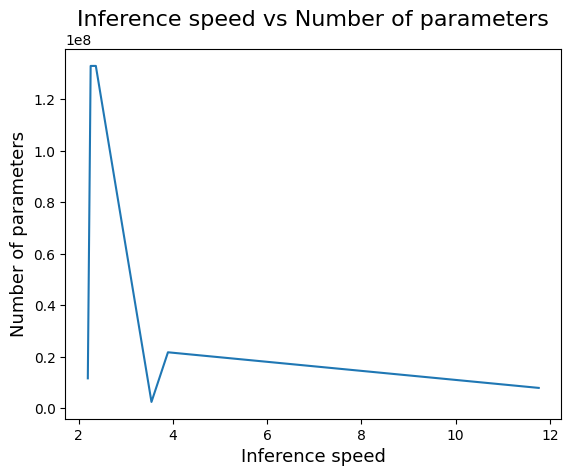

In [79]:
inference_speed_times = [info.get_inference_speed() for info in info_no_gradients]
num_parameters = [info.get_num_parameters() for info in info_no_gradients]

print(inference_speed_times)
print(num_parameters)

inference_speed_times, num_parameters = zip(*sorted(zip(inference_speed_times, num_parameters)))

print(inference_speed_times)
print(num_parameters)

plt.title("Inference speed vs Number of parameters", fontsize="16")
plt.plot(inference_speed_times, num_parameters)
plt.xlabel("Inference speed", fontsize="13")
plt.ylabel("Number of parameters", fontsize="13")
plt.show()

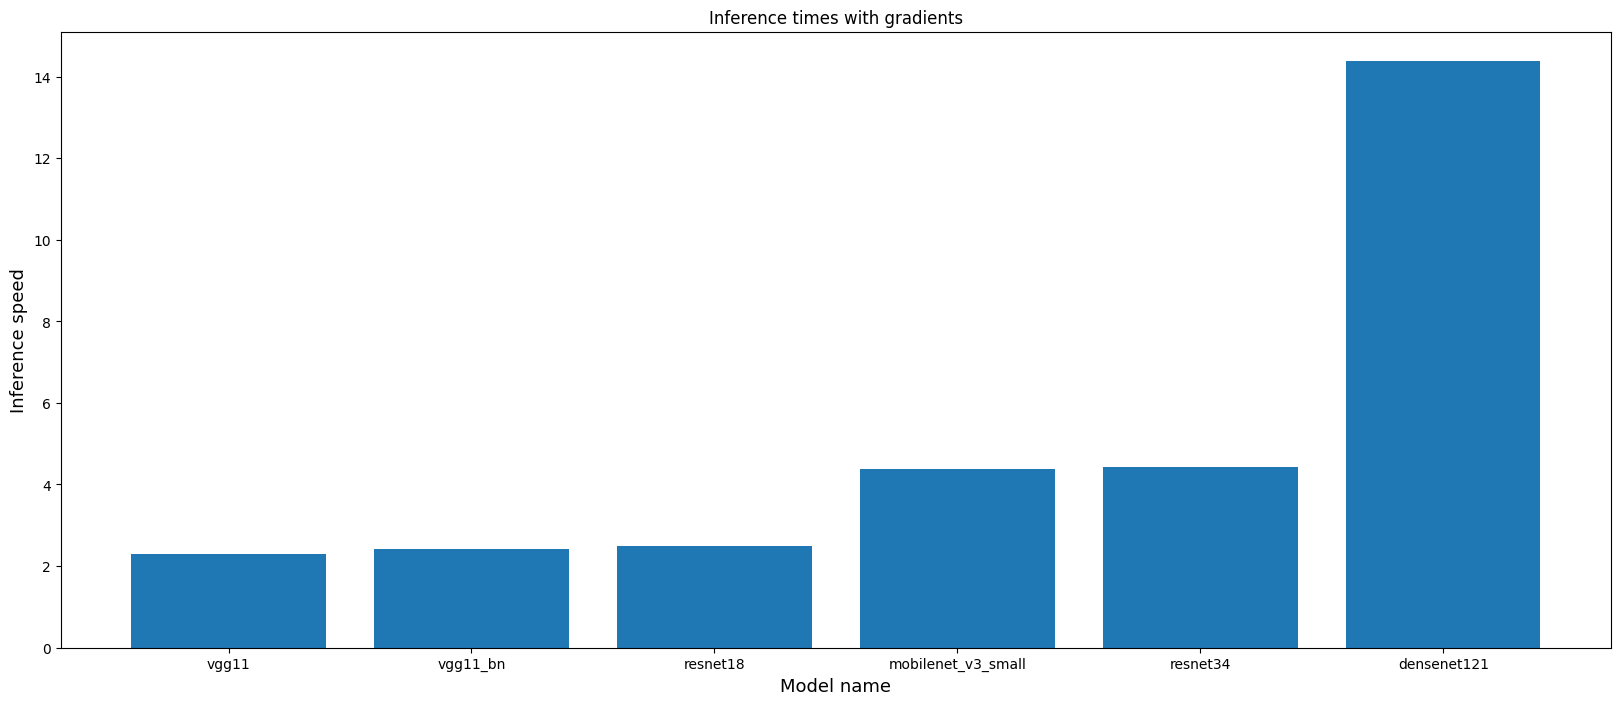

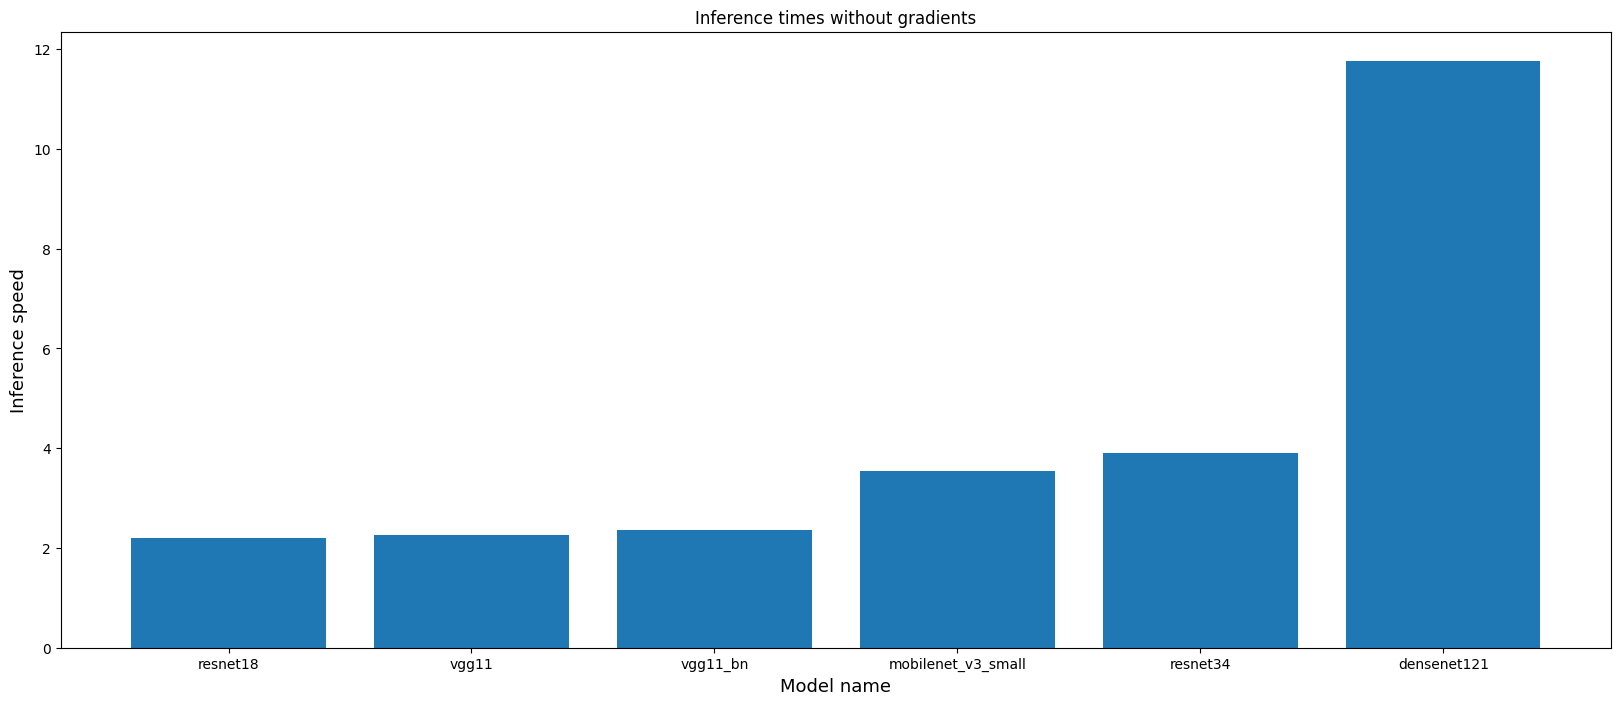

In [80]:
inference_speed_times = [info.get_inference_speed() for info in info_with_gradients]
model_names = [info.get_model_name() for info in info_with_gradients]

inference_speed_times, model_names = zip(*sorted(zip(inference_speed_times, model_names)))

fig = plt.figure(1, [20, 8])

plt.title("Inference times with gradients")
plt.bar(model_names, inference_speed_times)
plt.xlabel("Model name", fontsize="13")
plt.ylabel("Inference speed", fontsize="13")
plt.show()

inference_speed_times = [info.get_inference_speed() for info in info_no_gradients]
model_names = [info.get_model_name() for info in info_no_gradients]

inference_speed_times, model_names = zip(*sorted(zip(inference_speed_times, model_names)))

fig = plt.figure(1, [20, 8])

plt.title("Inference times without gradients")
plt.bar(model_names, inference_speed_times)
plt.xlabel("Model name", fontsize="13")
plt.ylabel("Inference speed", fontsize="13")
plt.show()

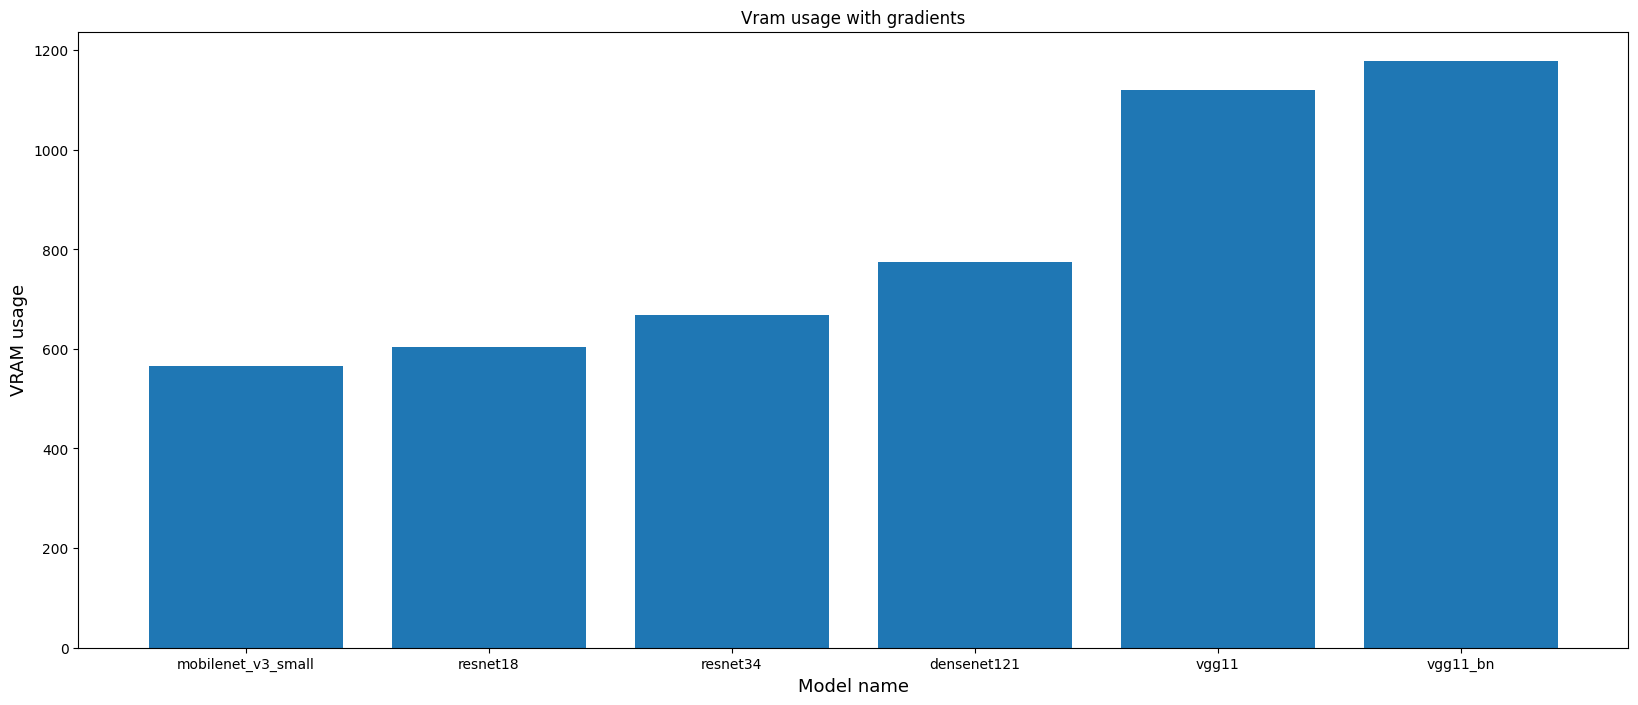

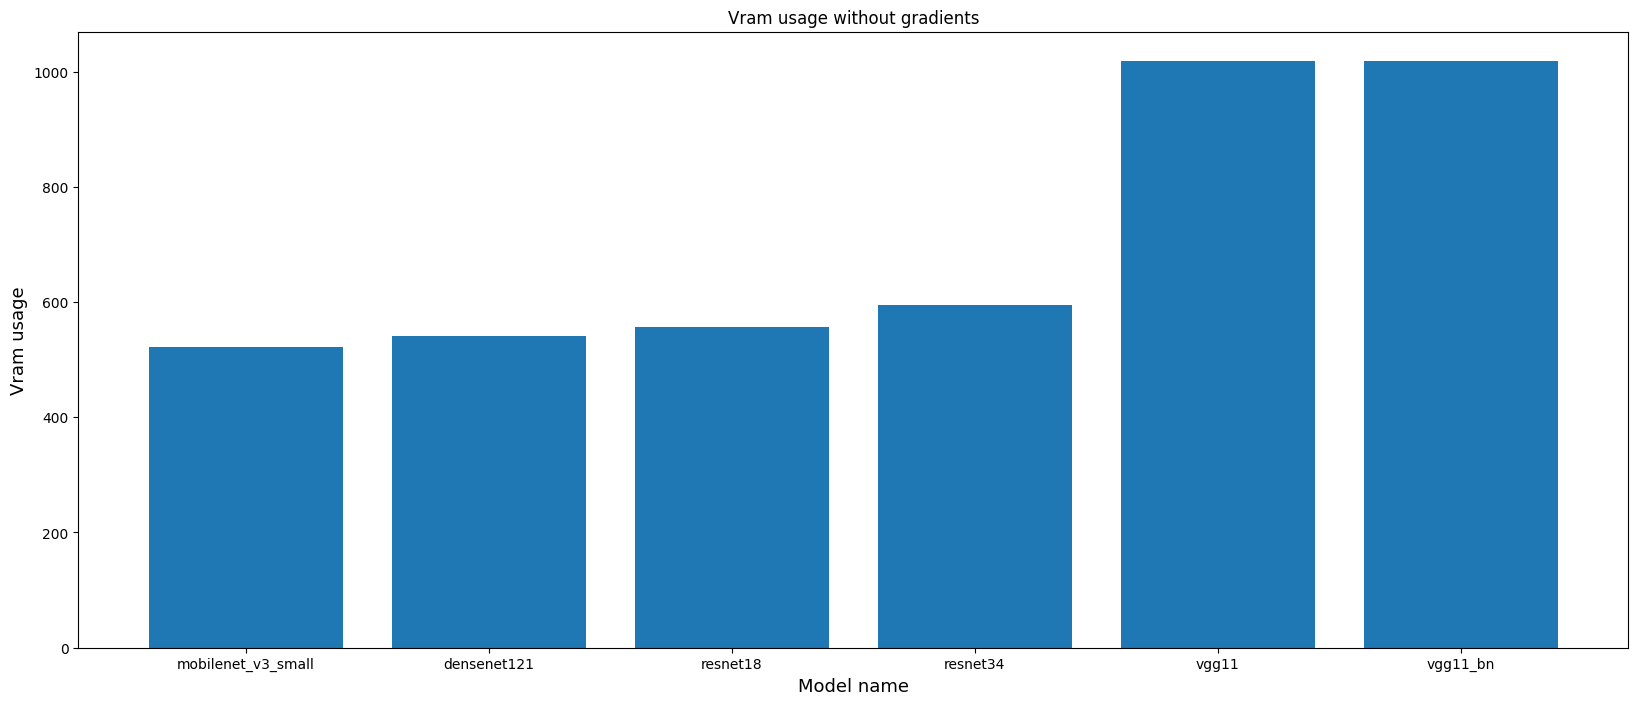

In [81]:
# convert bytes to MB
vram_usage = [info.get_vram_usage() / (1024 * 1024) for info in info_with_gradients]
model_names = [info.get_model_name() for info in info_with_gradients]

vram_usage, model_names = zip(*sorted(zip(vram_usage, model_names)))

fig = plt.figure(1, [20, 8])

plt.title("Vram usage with gradients")
plt.bar(model_names, vram_usage)
plt.xlabel("Model name", fontsize="13")
plt.ylabel("VRAM usage", fontsize="13")
plt.show()

vram_usage = [info.get_vram_usage() / (1024 * 1024) for info in info_no_gradients]
model_names = [info.get_model_name() for info in info_no_gradients]

vram_usage, model_names = zip(*sorted(zip(vram_usage, model_names)))

fig = plt.figure(1, [20, 8])

plt.title("Vram usage without gradients")
plt.bar(model_names, vram_usage)
plt.xlabel("Model name", fontsize="13")
plt.ylabel("Vram usage", fontsize="13")
plt.show()